<center> <b>A2C on LunarLander-v2</b></center>

In [29]:
# Install dependencies:-
# !pip install gym
# !pip install pygame
# !pip install Box2D
# !pip install gym[all]
# !pip install gym[box2d]
# !pip3 install box2d box2d-kengz

In [30]:
import gym, os
from gym import spaces
from itertools import count
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import math
from gym import envs

plt.style.use('ggplot')

torch.seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
from actor import Actor
from critic import Critic

In [32]:
env = gym.make('LunarLander-v2')

In [33]:
def a2c(max_episodes, gamma, alphaA, alphaC):
    max_episodes = max_episodes
    env.reset()
    total_rewards = []
    log_probs = []
    values = []
    rewards = []
    masks = []
    actor = Actor().to(device)
    critic = Critic().to(device)

    optimizer_a = torch.optim.Adam(actor.parameters(), lr= alphaA)
    optimizer_c = torch.optim.Adam(critic.parameters(), lr= alphaC)

    for i in range(max_episodes):
      done=False
      state= env.reset()
      r=0
      u = 0 
      d = 1 
      log_probs = []
      values = []
      rewards = []
      masks = []
      episode_entropy = 0
    
      loss_a_list = []
      actor_losses= 0
      q_val = 0
      
      while not done:
          
          value = critic(torch.Tensor(state).to(device))
          act_prob = actor(torch.Tensor(state).to(device))

          #detaching to numbers for calculation
          value = value.cpu().detach().numpy()[0]
          prob = act_prob.cpu().detach().numpy() + 0.000001 #to avoid runtime error
          #env.render()
          
        #sample an action
          action = torch.multinomial(act_prob,1 ).cpu().detach().numpy()[0]

          log_prob = torch.log(act_prob.squeeze(0)[action])

          entropy = -np.sum(np.mean(prob) * np.log(prob))

        #pass action in env
          next_state,reward,done, info = env.step(action)
          reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
          r+=reward
          rewards.append(reward)
          values.append(value)
          log_probs.append(log_prob)
          episode_entropy += entropy
          state = next_state

          qval = critic(torch.Tensor(next_state).to(device))
          qval = qval.detach().cpu().numpy()[0]

      qvals = np.zeros_like(values)
      for t in reversed(range(len(rewards))):
          qval = rewards[t] + gamma * qval
          qvals[t] = qval

      values = torch.FloatTensor(values).to(device)
      qvals = torch.FloatTensor(qvals).to(device)
      log_probs = torch.stack(log_probs).to(device)

      advantage = qvals - values

      actor_loss = (-log_probs * advantage).mean() + 0.001 * episode_entropy
      critic_loss = 0.5 * advantage.pow(2).mean()  + 0.001 * episode_entropy
      critic_loss.requires_grad =True

      optimizer_a.zero_grad()
      optimizer_c.zero_grad()

      actor_loss.backward()
      critic_loss.backward()

      optimizer_a.step()
      optimizer_c.step()   
      

      total_rewards.append(r)
      if i%10 == 0:
        print("Episode: ",i," Last  10 eps avg reward: ",sum(total_rewards[-10:])/10)
    
      if sum(total_rewards[-10:])/10 >= 225:
          print("Training Completed !!")

          #saving models
          torch.save(actor.state_dict(), 'a2c_actor.pt')
          torch.save(critic.state_dict(), 'a2c_critic.pt')
          break
    
    plt.plot(total_rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Rewards")
  

def testing_a2c(max_eps, actor):
    total_rews=[]
    actor.eval()

    for i in range(max_eps):
        state = env.reset()
        done = False
        r = 0
        while not done:
            
            env.render()

            act_prob = actor(torch.Tensor(state).to(device))        
            action = torch.multinomial(act_prob,1 ).cpu().detach().numpy()[0]
            next_state,reward,done, info = env.step(action)
            r+=reward
            
            state = next_state
        total_rews.append(r)  
        print("Episode: ",i," Last 10 eps avg reward: ",total_rews[-1:][0])

        plt.plot(total_rews)
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title(" Evaluation Rewards")
        print("Average Reward during Evaluation: ", np.mean(total_rews))
        

<center>Training the agent</center>

Episode:  0  Last  10 eps avg reward:  -9.897573641639216
Episode:  10  Last  10 eps avg reward:  -93.26357358261681
Episode:  20  Last  10 eps avg reward:  -96.92346397153155
Episode:  30  Last  10 eps avg reward:  -98.59972681767525
Episode:  40  Last  10 eps avg reward:  -71.81673425043357
Episode:  50  Last  10 eps avg reward:  155.69929301406643
Training Completed !!


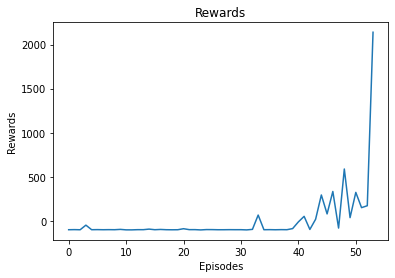

In [34]:
a2c(max_episodes=4000, gamma=0.99, alphaA=0.001, alphaC=0.001)

Testing

##### Testing code to load saved weights. Please use this code to test saved weights.
```
actor = Actor().to(device)
actor.load_state_dict(torch.load('generated/actor_LL.pt'))
critic = Critic().to(device)
critic.load_state_dict(torch.load('generated/critic_LL.pt'))

testing_a2c(10, actor)
```

Episode:  0  Last 10 eps avg reward:  270.40791047704283
Average Reward during Evaluation:  270.40791047704283


KeyboardInterrupt: 

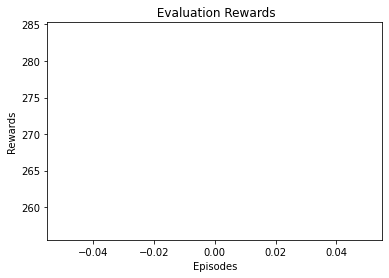

In [35]:
actor = Actor().to(device)
actor.load_state_dict(torch.load('actor_LL.pt'))
critic = Critic().to(device)
critic.load_state_dict(torch.load('critic_LL.pt'))

testing_a2c(10, actor)